### Import data set (using sklearn for this)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False #,parser = "pandas"
)

X = X/ 255.0
y_enc = OneHotEncoder().fit_transform(y[:, np.newaxis]).toarray()

np.random.seed(42)
train_samples = 6000
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, train_size=train_samples, test_size=10000, random_state = 42
)
val_samples = 1000
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_samples, random_state = 42
)

 

In [133]:
len(y_val)

1000

Lets look at an example

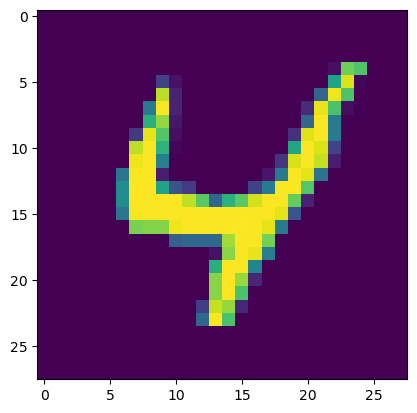

In [137]:
example = np.reshape(X_train[3],[28,28])
plt.imshow(example)

In [138]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

Define the activations

In [139]:
def relu(x):
    return (x > 0) * x         

def relu2deriv(output):
    return output>0            

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x/np.sum(e_x, axis = 1) 

In [140]:
import warnings
warnings.filterwarnings("error")

Brute force training, just walking though each training example. (not even stochastic). This could be improved:
* add validation set
* better models!

But this serves for what I want to look at here

In [141]:

class SimpMNISTNet:
   def __init__(self, hidden_size):
      self.hidden_size = hidden_size
      self.weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
      self.weights_1_2 = 2*np.random.random((hidden_size,10)) - 1
      self.bias_1 = np.zeros([1,hidden_size])
      self.bias_2 = np.zeros([1,10])

   def predict(self, X):
      layer_1 = relu(np.dot(X,self.weights_0_1) + self.bias_1)
      return softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
   
   def single_epoch_train(self, X, y, alpha, batch_size):
      eps = 10**-9
      indices = [*range(len(y))]
      np.random.shuffle(indices)
      batch_ind = [indices[i:i+batch_size] for i in range(0, len(indices), batch_size)]
      layer_2_error = 0
      for batch in batch_ind:
         layer_2_delta_b = np.zeros([1,10])
         layer_1_2_delta_w = np.zeros([self.hidden_size,10])
         layer_1_delta_b = np.zeros([1,self.hidden_size])
         layer_0_1_delta_w = np.zeros([28*28,self.hidden_size])
         for i in batch:
            layer_0 = X[i:i+1]
            layer_1 = relu(np.dot(layer_0,self.weights_0_1) + self.bias_1)
            layer_2 = softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
            layer_2_error -= y[i:i+1].dot(np.log(layer_2 + eps).T)
            #layer_2_delta =  -y[i:i+1]*(1-layer_2)
            layer_2_delta =   layer_2 - y[i:i+1]
            layer_1_delta = layer_2_delta.dot(self.weights_1_2.T)*relu2deriv(layer_1)
            layer_1_delta_b += layer_1_delta
            layer_2_delta_b += layer_2_delta
            layer_1_2_delta_w += layer_1.T.dot(layer_2_delta)
            layer_0_1_delta_w += layer_0.T.dot(layer_1_delta)
         self.weights_1_2 -= alpha * layer_1_2_delta_w /len(batch)
         self.bias_2 -= alpha*layer_2_delta_b /len(batch)      
         self.weights_0_1 -= alpha * layer_0_1_delta_w /len(batch)
         self.bias_1 -= alpha*layer_1_delta_b / len(batch)
      return layer_2_error


   def sgd(self, X, y, X_val, y_val, alpha, batch_size, epochs):
      for iteration in range(epochs):
         error = self.single_epoch_train(X, y, alpha, batch_size)
         if((iteration + 1) % 10 ==0):
             print("Error:" + str(error) + " iter: " + str(iteration+1))
             corr = 0
             for i in range(len(y_val)):
                 corr += np.argmax(y_val[i]) == np.argmax(self.predict(X_val[i]))
             print("Val error:" + str(corr/len(y_val)))







In [142]:
alpha = 0.0003
np.random.seed(1)
model = SimpMNISTNet(100)
model.sgd(X_train, y_train, X_val, y_val, alpha, 50, 200)

Error:[[55158.40450503]] iter: 10
Val error:0.221
Error:[[41381.18853247]] iter: 20
Val error:0.341
Error:[[32001.62189283]] iter: 30
Val error:0.417
Error:[[26070.39206892]] iter: 40
Val error:0.487
Error:[[22217.22099443]] iter: 50
Val error:0.528
Error:[[19532.59701891]] iter: 60
Val error:0.567
Error:[[17538.69386708]] iter: 70
Val error:0.591
Error:[[16003.76349825]] iter: 80
Val error:0.616
Error:[[14772.7110725]] iter: 90
Val error:0.634
Error:[[13753.75868513]] iter: 100
Val error:0.649
Error:[[12894.50367047]] iter: 110
Val error:0.66
Error:[[12154.71337619]] iter: 120
Val error:0.673
Error:[[11512.65614865]] iter: 130
Val error:0.688
Error:[[10947.04404412]] iter: 140
Val error:0.696
Error:[[10447.71732924]] iter: 150
Val error:0.706
Error:[[10000.96422778]] iter: 160
Val error:0.713
Error:[[9597.8269667]] iter: 170
Val error:0.722
Error:[[9231.95332301]] iter: 180
Val error:0.729
Error:[[8900.84878588]] iter: 190
Val error:0.738
Error:[[8596.85489364]] iter: 200
Val error:0.

In [143]:
model.sgd(X_train, y_train, X_val, y_val, alpha, 50, 100)

Error:[[8318.31143315]] iter: 10
Val error:0.746


In [98]:
y_train[3]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [99]:
model.predict(X_train[3])

array([[1.27036424e-04, 3.82028543e-04, 3.27728823e-03, 2.75178593e-14,
        1.57753645e-13, 2.88953349e-09, 4.62304317e-10, 5.71474976e-12,
        8.84237057e-02, 9.07789938e-01]])

In [101]:
corr = 0
for i in range(len(y_test)):
    corr += np.argmax(y_test[i]) == np.argmax(model.predict(X_test[i]))

corr/len(y_test)

0.7249

Thats not bad at all, I think one can do better though with more training examples and time.

Look at weights. in the hidden layer each unit has 781 weights which can be seen as an 'image' that gets dotted with the test image to see if it correlates.  There is one of these 'images' for each hidden layer.  Which are important for figuring out that a digit is a 2?

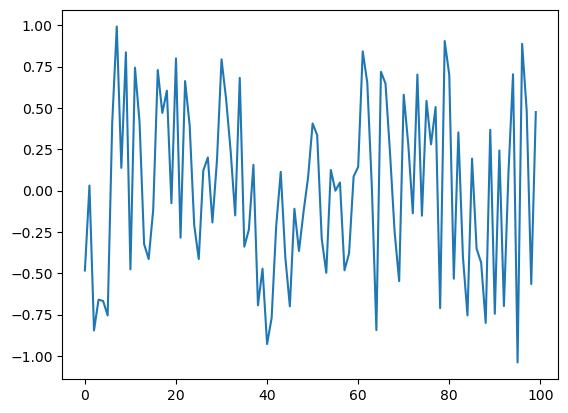

In [106]:
plt.plot(model.weights_1_2[:,2]) 

In [103]:
np.argsort(model.weights_1_2[:,2])[-3:]

array([96, 79,  7])

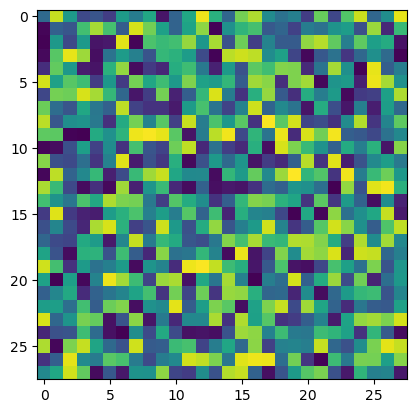

In [104]:
plt.imshow(np.reshape(model.weights_0_1[:,7],[28,28]))

Somehow this pattern correlates with a 2, or at least in part. Lets try from other direction

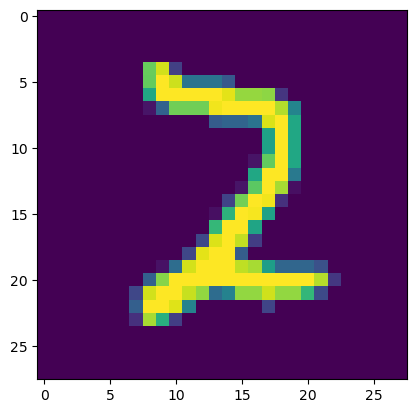

In [124]:
plt.imshow(np.reshape(X_test[14],[28,28]))

In [125]:
np.argmax(model.predict(X_test[14]))

2

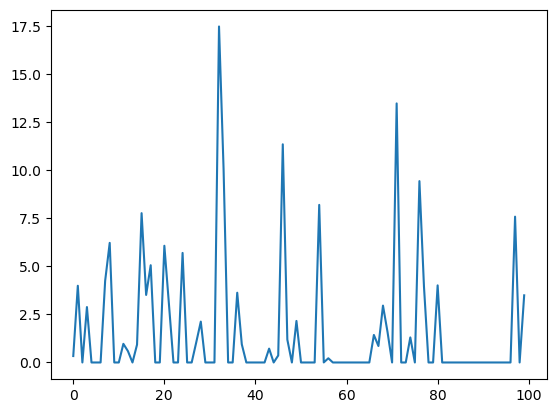

In [126]:
layer_1_test = relu(np.dot(X_test[14],model.weights_0_1) + model.bias_1)
plt.plot(layer_1_test[0])

In [127]:
np.argsort(layer_1_test[0])[-3:]

array([46, 71, 32])

the biggest layer activated looks like

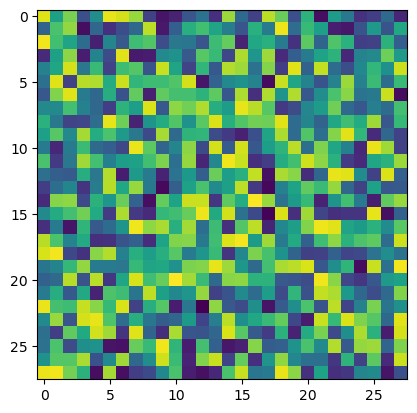

In [128]:
plt.imshow(np.reshape(model.weights_0_1[:,32],[28,28]))

Oddly this is not one of the biggest ones that feed into '2' in the output. But it is one of them.  It does have a certain 2 -ness.